# Example of training classification baselines
## For reproducing the results in the paper

In [17]:
import pandas as pd
import numpy as np
import os 
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
import seaborn as sns
import shap

from utils.data_utils import correct_col_type,gen_date_col,transform_category_to_counts,min_max_perpatient

In [18]:
# Please change the path with the path of your dataset
DPATH = '../Dataset/'
SAVE_PATH = './figs/'

In [19]:
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [20]:
# Read all tables into data_dict

files = os.listdir(DPATH)
data_dict = {}
summaries = {}
for f in files:
    if 'csv' not in f:
        continue
    print(f)
    fpth = os.path.join(DPATH,f)
    df = pd.read_csv(fpth)

    for col in df.columns:
        df[col] = correct_col_type(df,col)
    if 'date' in df.columns:
        df = df.rename(columns={'date':'timestamp'})
                
    fname = f.split('.')[0]
    data_dict[fname] = df

Activity.csv
Demographics.csv
Labels.csv
Physiology.csv
Sleep.csv


In [21]:
## Generate a date column for Labels and Activity table 
lbl_df = gen_date_col(data_dict['Labels'],tcol='timestamp')
act_df1 = gen_date_col(data_dict['Activity'],tcol='timestamp')

## Generate a hour column for Activity table 
act_df1['hour'] = act_df1.timestamp.dt.hour
act_df = transform_category_to_counts(act_df1,col='location_name',keys=['patient_id','date','hour'])

In [22]:
## Aggregate doors
act_df['Door'] = act_df['Front Door'] + act_df['Back Door']
act_df = act_df.drop(columns=['Front Door','Back Door'])
act_df.head()

location_name,patient_id,date,hour,Bathroom,Bedroom,Fridge Door,Hallway,Kitchen,Lounge,Door
0,0697d,2019-06-28,13,5,10,21,9,10,14,24
1,0697d,2019-06-28,14,0,7,2,9,20,16,7
2,0697d,2019-06-28,15,0,0,0,3,5,6,0
3,0697d,2019-06-28,16,0,0,0,0,10,6,0
4,0697d,2019-06-28,17,0,1,0,9,12,7,8


In [23]:
## generate features by statistics of hourly counts for each day, ##
## missing values will not be counted ##

keys = ['patient_id','date']
act_df.drop('hour',axis=1,inplace=True)
act_cols = list(act_df.set_index(keys).columns)
agg_fns = {'sum':act_cols,'std':act_cols,'mean':act_cols,'max':act_cols}#{'sum':act_cols,'std':act_cols,'max':act_cols,'mean':act_cols}#
methods = {}
for agf,cols in agg_fns.items():
    print(agf)
    methods[agf] = act_df.loc[:,cols+keys].groupby(keys).agg(agf)
    
tmp_df=None

for mhd,tdf in methods.items():
    cols = tdf.columns
    vcols = [c+'_count_'+mhd for c in cols]
    if tmp_df is None:
        tmp_df = tdf
    tmp_df[vcols] = tdf.loc[tmp_df.index,cols]

act_df = tmp_df.drop(act_cols,axis=1)
act_df.head()

sum
std
mean
max


location_name          Bathroom_count_sum  Bedroom_count_sum  \
patient_id date                                                
0697d      2019-04-01                   0                  0   
           2019-04-03                   0                  0   
           2019-04-04                   0                  0   
           2019-04-05                   0                  0   
           2019-04-06                   0                  0   

location_name          Fridge Door_count_sum  Hallway_count_sum  \
patient_id date                                                   
0697d      2019-04-01                      0                  0   
           2019-04-03                      0                  0   
           2019-04-04                      0                  0   
           2019-04-05                      0                  0   
           2019-04-06                      0                  0   

location_name          Kitchen_count_sum  Lounge_count_sum  Door_count_sum  \
patient_id date                                                              
0697d      2019-04-01                  0                 0               0   
           2019-04-03                  0                 0               0   
           2019-04-04                  0                 0               0   
           2019-04-05                  0                 0               0   
           2019-04-06                  0                 0               0   

location_name          Bathroom_count_std  Bedroom_count_std  \
patient_id date                                                
0697d      2019-04-01                 NaN                NaN   
           2019-04-03                 NaN                NaN   
           2019-04-04                 NaN                NaN   
           2019-04-05                 NaN                NaN   
           2019-04-06                 NaN                NaN   

location_name          Fridge Door_count_std  ...  Kitchen_count_mean  \
patient_id date                               ...                       
0697d      2019-04-01                    NaN  ...                 NaN   
           2019-04-03                    NaN  ...                 NaN   
           2019-04-04                    NaN  ...                 NaN   
           2019-04-05                    NaN  ...                 NaN   
           2019-04-06                    NaN  ...                 NaN   

location_name          Lounge_count_mean  Door_count_mean  Bathroom_count_max  \
patient_id date                                                                 
0697d      2019-04-01                NaN              NaN                 NaN   
           2019-04-03                NaN              NaN                 NaN   
           2019-04-04                NaN              NaN                 NaN   
           2019-04-05                NaN              NaN                 NaN   
           2019-04-06                NaN              NaN                 NaN   

location_name          Bedroom_count_max  Fridge Door_count_max  \
patient_id date                                                   
0697d      2019-04-01                NaN                    NaN   
           2019-04-03                NaN                    NaN   
           2019-04-04                NaN                    NaN   
           2019-04-05                NaN                    NaN   
           2019-04-06                NaN                    NaN   

location_name          Hallway_count_max  Kitchen_count_max  Lounge_count_max  \
patient_id date                                                                 
0697d      2019-04-01                NaN                NaN               NaN   
           2019-04-03                NaN                NaN               NaN   
           2019-04-04                NaN                NaN               NaN   
           2019-04-05                NaN                NaN               NaN   
           2019-04-06                NaN         

In [24]:
## Aggreate Physiology table in a daily basis by maximum values
phys_df = gen_date_col(data_dict['Physiology'],tcol='timestamp')
phys_df = phys_df.groupby(['patient_id','date','device_type']).agg('max')
phys_df.drop(phys_df.loc[phys_df.sum(axis=1)==0].index,axis=0,inplace=True)
phys_df.reset_index(inplace=True)

phys_df = phys_df.pivot_table(values = 'value', columns='device_type', index=['patient_id','date'])
phys_df.head()

device_type            Body Temperature  Body weight  \
patient_id date                                        
0697d      2019-06-28            36.599         86.3   
           2019-06-29            37.257         86.1   
           2019-06-30            36.779          NaN   
099bc      2019-05-15            40.876         53.3   
           2019-05-16            37.045         52.7   

device_type            Diastolic blood pressure  Heart rate  \
patient_id date                                               
0697d      2019-06-28                      82.0        42.0   
           2019-06-29                      80.0        62.0   
           2019-06-30                      83.0        55.0   
099bc      2019-05-15                      88.0        99.0   
           2019-05-16                      78.0        71.0   

device_type            O/E - muscle mass  Skin Temperature  \
patient_id date                                              
0697d      2019-06-28               64.5               NaN   
           2019-06-29               64.6               NaN   
           2019-06-30                NaN               NaN   
099bc      2019-05-15               39.8               NaN   
           2019-05-16                NaN               NaN   

device_type            Systolic blood pressure  Total body water  
patient_id date                                                   
0697d      2019-06-28                    165.0              50.6  
           2019-06-29                    168.0              51.2  
           2019-06-30                    158.0               NaN  
099bc      2019-05-15                    141.0              54.0  
           2019-05-16                    152.0               NaN

In [25]:
## Set parameters for cross-validation

window = pd.Timedelta('7D')     # time window of test set
K = 5     # 5-fold cross-validation
sd=0      # random seed
keys = ['patient_id','date']
label_type = 'Agitation'

lbl_df = lbl_df.set_index(keys)
label_scores = {}
shap_values, tX = {}, []

In [26]:
## Merge Activity and Physiology tables

X = act_df.merge(phys_df,how='outer',right_index=True,left_index=True).fillna(0)        
X.drop(X.index[X.sum(axis=1)==0],axis=0,inplace=True)

inter_ids = set(X.index) & set(lbl_df[lbl_df.type==label_type].index)

X['label']=0
X.loc[inter_ids,'label']=1

if 'date' not in X.columns:
    X = X.reset_index()

X = min_max_perpatient(X,skip=['label']) 

dates = np.sort(X.loc[X.label==1].date)
end_date = dates[-1]

In [27]:
## Training and evaluating baselines

for k in range(K):
    split = end_date - window
    train_X = X.loc[(pd.to_datetime(X.date)-pd.to_datetime(split))<=pd.Timedelta(0,'D')]
    test_X = X.loc[((pd.to_datetime(X.date)-pd.to_datetime(split))>pd.Timedelta(0,'D'))
                   &((pd.to_datetime(X.date)-pd.to_datetime(split))<=window)]
    print('check date',np.sort(train_X.date)[-1],np.sort(test_X.date)[-1],np.sort(test_X.date)[0])
    end_date = split

    train_X = train_X.drop(keys,axis=1)
    test_X = test_X.drop(keys,axis=1)

    if test_X.label.sum()==0:
        print('No positive labels in test set!')
        continue

    test_y = test_X.label.values
    train_y = train_X.label.values


    train_X = train_X.drop('label',axis=1).values
    test_X = test_X.drop('label',axis=1).values        

    tX.append(test_X)



    ros = RandomOverSampler(random_state=sd)
    train_X, train_y = ros.fit_resample(train_X, train_y)

    CLFs = [GradientBoostingClassifier(n_estimators=20,min_samples_leaf=1,random_state=sd),
           MLPClassifier(hidden_layer_sizes=(128,128),max_iter=300,activation='tanh',alpha=0.001,early_stopping=True,random_state=sd),
           LogisticRegression(max_iter=5000,random_state=sd),
           GaussianNB(),
           GaussianProcessClassifier(random_state=sd),]
    print('Test {}, positive proportion: {}'.format(k,test_y.sum()/test_y.shape[0]))
    for clf in CLFs:
        print(clf)
        scores = {}
        label_scores[clf.__class__.__name__]=label_scores.get(clf.__class__.__name__,{})


        clf.fit(train_X,train_y)
        pred_y = clf.predict(test_X)
        
        cmx = confusion_matrix(test_y,pred_y)
        print('confusion matrix on separate validation set',cmx)


        sensitivity = cmx[1,1]/cmx[1,:].sum()
        sc = scores.get('sensitivity',[])
        sc.append(sensitivity)
        scores['sensitivity']=sc

        specificity = cmx[0,0]/cmx[0,:].sum()
        sc = scores.get('specificity',[])
        sc.append(specificity)
        scores['specificity']=sc

        label_scores[clf.__class__.__name__][label_type] = label_scores[clf.__class__.__name__].get(label_type,{})

        label_scores[clf.__class__.__name__][label_type][k]=scores

        if isinstance(clf,GradientBoostingClassifier):
            explainer = shap.TreeExplainer(clf, model_output='probability', data=train_X)
            shap_values[clf.__class__.__name__] = shap_values.get(clf.__class__.__name__,[])
            shap_values[clf.__class__.__name__].append(explainer.shap_values(test_X))

        if isinstance(clf,LogisticRegression):
            explainer = shap.LinearExplainer(clf, model_output='probability', data=train_X,masker=train_X)
            shap_values[clf.__class__.__name__] = shap_values.get(clf.__class__.__name__,[])
            shap_values[clf.__class__.__name__].append(explainer.shap_values(test_X))

check date 2019-06-22 2019-06-29 2019-06-23
Test 0, positive proportion: 0.028011204481792718
GradientBoostingClassifier(n_estimators=20, random_state=0)
confusion matrix on separate validation set [[289  58]
 [  2   8]]
MLPClassifier(activation='tanh', alpha=0.001, early_stopping=True,
              hidden_layer_sizes=(128, 128), max_iter=300, random_state=0)
confusion matrix on separate validation set [[305  42]
 [  3   7]]
LogisticRegression(max_iter=5000, random_state=0)
confusion matrix on separate validation set [[271  76]
 [  0  10]]
GaussianNB()
confusion matrix on separate validation set [[226 121]
 [  0  10]]
GaussianProcessClassifier(random_state=0)
confusion matrix on separate validation set [[307  40]
 [  3   7]]
check date 2019-06-15 2019-06-22 2019-06-16
Test 1, positive proportion: 0.025477707006369428
GradientBoostingClassifier(n_estimators=20, random_state=0)
confusion matrix on separate validation set [[275  31]
 [  3   5]]
MLPClassifier(activation='tanh', alpha=0.00

In [28]:
## Summarise the performance of baselines 

re_table_mean = {}
re_table_std = {}
re_table_dist = {'sensitivity':{},'specificity':{}}
for k in label_scores.keys():
    print('#############################################')
    print(k)
    re_table_mean[k]={}
    re_table_std[k]={}
    
    for kk in label_scores[k].keys():
        print(kk)
        #re_table_mean[k][kk]={}
        #re_table_std[k][kk]={}
        sensitivity, specificity = [],[]
        for sc in label_scores[k][kk].values():
            sensitivity.append(sc['sensitivity'])
            specificity.append(sc['specificity'])
            
        print('sensitivity mean {}, std {}'.format(np.mean(sensitivity),np.std(sensitivity)))
        print('specificity mean {}, std {}'.format(np.mean(specificity),np.std(specificity)))
        
        re_table_mean[k]['sensitivity']= np.mean(sensitivity)
        re_table_mean[k]['specificity']= np.mean(specificity)
        
        re_table_std[k]['sensitivity']= np.std(sensitivity)
        re_table_std[k]['specificity']= np.std(specificity)
        
        re_table_dist['sensitivity'][k]=np.array(sensitivity).reshape(-1)
        re_table_dist['specificity'][k]=np.array(specificity).reshape(-1)

#############################################
GradientBoostingClassifier
Agitation
sensitivity mean 0.60091579775723, std 0.12094377066573006
specificity mean 0.8586429687450334, std 0.024164418231577
#############################################
MLPClassifier
Agitation
sensitivity mean 0.671084005508558, std 0.09481158664794555
specificity mean 0.8875197041255161, std 0.039855685866403645
#############################################
LogisticRegression
Agitation
sensitivity mean 0.7993950422978556, std 0.1272118423686365
specificity mean 0.8120772973184872, std 0.039585461767368824
#############################################
GaussianNB
Agitation
sensitivity mean 0.7794855400354121, std 0.17508974751109735
specificity mean 0.709400073719469, std 0.04048029852034762
#############################################
GaussianProcessClassifier
Agitation
sensitivity mean 0.5814666535510524, std 0.11634537140493569
specificity mean 0.906646613804915, std 0.012380649138887765


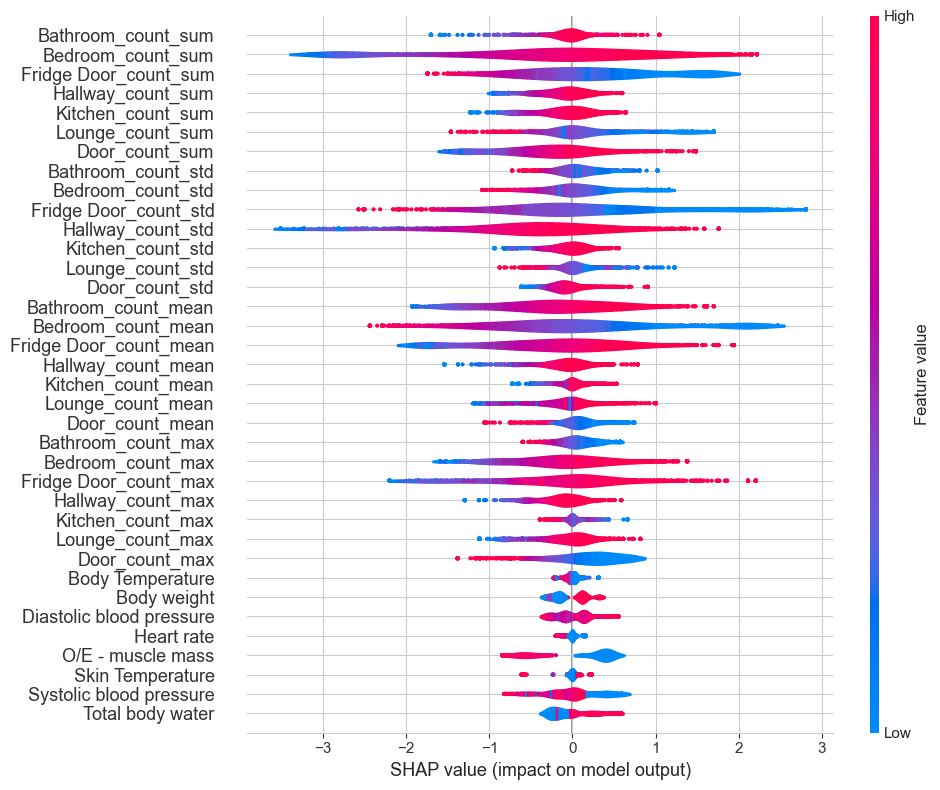

<Figure size 640x480 with 0 Axes>

In [29]:
## Plot SHAP values

feature_names = X.columns[2:]
fig, ax = plt.subplots() 
shap.summary_plot(np.vstack(shap_values['LogisticRegression']), 
                            np.vstack(tX), 
                            feature_names=feature_names, 
                            plot_type='violin', 
                            show=False,
                            plot_size=(10,8), 
                            sort=False, max_display=len(feature_names)
                            )
plt.show()
plt.close()
plt.savefig(SAVE_PATH + 'shap_LR.svg')

In [30]:
clf_names = ['Gadient Boosting Trees','MLP','Logistic Regression','Naive Bayes','Gaussian Process']
mean_df = pd.DataFrame(re_table_mean)
std_df = pd.DataFrame(re_table_std)

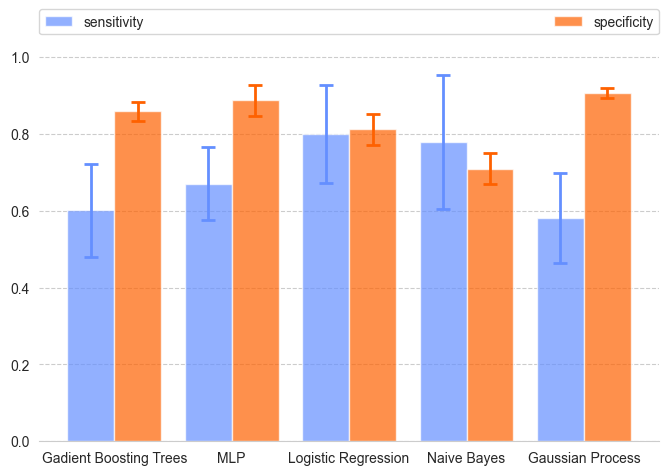

In [31]:
## Visualise performance of baselines

ibm_colorblind = ['#648FFF', '#FE6100', '#DC267F', '#785EF0', '#FFB000','#48A9A6']
sns.set_palette(ibm_colorblind)
sns.set_style("whitegrid",{'axes.grid': False,'grid.linestyle': '--', 'axes.spines.left':False,
                            'axes.spines.right':False,'axes.spines.top':False})

plt.figure(figsize=[8,5])
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.bar(x=np.arange(len(clf_names))-0.2,height=mean_df.loc['sensitivity'].values,width=0.4,alpha=0.7,yerr=std_df.loc['sensitivity'].values,error_kw=dict(ecolor=colors[0], lw=2, capsize=5, capthick=2))
plt.bar(x=np.arange(len(clf_names))+0.2,height=mean_df.loc['specificity'].values,width=0.4,alpha=0.7,yerr=std_df.loc['specificity'].values,error_kw=dict(ecolor=colors[1], lw=2, capsize=5, capthick=2))
plt.xticks(np.arange(len(clf_names)),labels=clf_names,fontsize=10)
plt.yticks(np.arange(0.,1.1,0.2))
plt.legend(['sensitivity','specificity'],bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center',
           ncol=2, mode="expand", borderaxespad=0)
plt.grid(visible=True, axis='y')
plt.savefig(SAVE_PATH + 'baselines_agitation.svg')

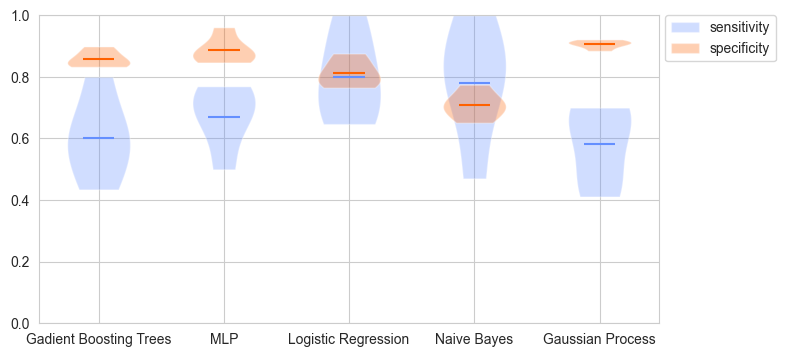

In [32]:
## Visualise distribution of performance of baselines

sns.set_style("whitegrid")
plt.figure(figsize=[8,4])
v1 = plt.violinplot(np.array(pd.DataFrame(re_table_dist['sensitivity'])),vert=True,showmeans=True,showextrema=False)
v2 = plt.violinplot(np.array(pd.DataFrame(re_table_dist['specificity'])),vert=True,showmeans=True,showextrema=False)
plt.xticks(np.arange(len(clf_names))+1,labels=clf_names)
plt.ylim(0.,1.)
plt.legend([v1['bodies'][0],v2['bodies'][0]],['sensitivity','specificity'],loc=[1.01,0.85])